In [20]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import libraries

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC, LinearSVC, SVR
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import random
import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from ts2vec import TS2Vec

In [ ]:
from utils.ml_regression import train_and_evaluate_rf, train_and_evaluate_svr, train_and_evaluate_xgb, svr_grid_search, rf_grid_search

In [ ]:
from utils.ml_regression import tune_xgb_hyperparameters_random as tune_xgb

# Load datasets

In [24]:
def calculate_cdf(series, num_points=1024):
    sorted_series = np.sort(series)
    cdf = np.arange(1, len(sorted_series) + 1) / len(sorted_series)
    sampled_points = np.linspace(np.min(sorted_series), np.max(sorted_series), num_points)
    sampled_cdf = np.interp(sampled_points, sorted_series, cdf)
    return sampled_cdf

In [25]:
def load_dataset(files):
    data_arr = []
    for file_path in files:
        data_raw = pd.read_csv(file_path).values.astype(np.float32)
        if len(data_raw[:, 1]) == 0:
            print(f"Warning: No data in {file_path}")
            continue


        # data = np.expand_dims(data_raw[:, 1], axis=1)
        min_length = min(min_length, len(data_raw[:, 1]))
        cdf_features = calculate_cdf(data_raw[:, 1])        
        data_arr.append(cdf_features)
    
    return np.array(data_arr)

In [26]:
def load_files(files, max_len=None):
    data_arr = []
    
    for filepath in files:
        df = pd.read_csv(filepath)
        x = df['time'].astype(np.float32).values

        if len(x) == 0:
            print(f"File {filepath} is empty.")
            continue

        start = 0.05 * len(x)
        end = 0.95 * len(x)
        x = x[int(start):int(end)]

        if max_len is not None:
            if len(x) > max_len:
                x = x[:max_len]
            if len(x) < max_len:
                x = np.pad(x, (0, max_len - len(x)), 'constant', constant_values=(0))

        # x = np.expand_dims(x, axis=1)

        # cdf = calculate_cdf(x)

        data_arr.append(x)
    
    return np.array(data_arr)

In [27]:
data_storage = {
    'Join': {
        'dirs': [
            './nexmark_dataset/q3_join/actual_data',
            './nexmark_dataset/q4_join_auction_bid/actual_data',
        ],
        'label': 2,
        'substring': 'process_time',
        'end_char': '.'
    },
    'Max_GroupBy': {
        'dirs': [
            './nexmark_dataset/q6_max',
            './nexmark_dataset/q4_max',
        ],
        'label': 3,
        'substring': 'tail_0',
        'end_char': '.'
    },
    'Avg_Sliding': {
        'dirs': [
            './nexmark_dataset/q4_avg',
        ],
        'label': 4,
        'substring': 'tail_0',
        'end_char': '.'
    },
    'Avg_Partition': {
        'dirs': [
            './nexmark_dataset/avg_partition',
        ],
        'label': 5,
        'substring': 'tail_0',
        'end_char': '_'
    },
    'Count_By_Auction': {
        'dirs': [
            './nexmark_dataset/q5_count_by_auction',
        ],
        'label': 6,
        'substring': 'tail_0',
        'end_char': '.'
    },
}

In [28]:
class_names = [
    'Join', 
    'Max_GroupBy', 
    'Avg_Sliding', 
    'Avg_Partition',
    'Count_By_Auction',
]

In [29]:
data_files = {}
for operator in data_storage:
    data_files[operator] = {
        'files': [],
        'label': data_storage[operator]['label'],
    }

    for dir in data_storage[operator]['dirs']:
        files = [f for f in os.listdir(dir) if f.endswith('.csv')]
        data_files[operator]['files'].extend([os.path.join(dir, file) for file in files])

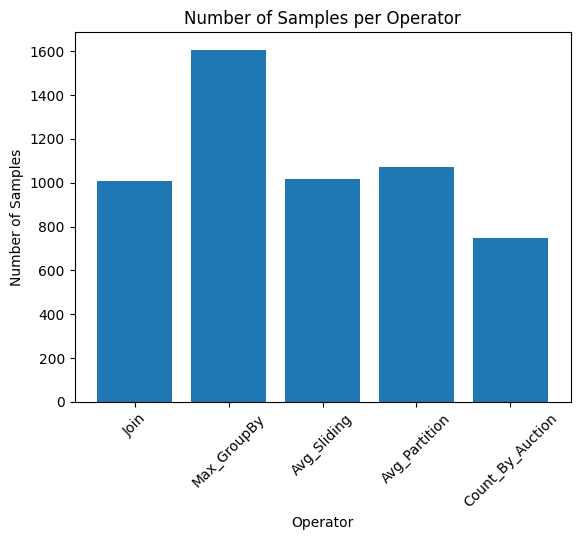

In [30]:
# Count the number of samples per operator
operator_counts = {operator: len(data_files[operator]['files']) for operator in data_files}

# Plot the data
plt.bar(operator_counts.keys(), operator_counts.values())
plt.xlabel('Operator')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Operator')
plt.xticks(rotation=45)
plt.show()

In [31]:
for operator in data_files:
    if operator == 'Join':
        data_files[operator]['train'] = data_files[operator]['files'][:504]
        data_files[operator]['test'] = data_files[operator]['files'][504:]
    elif operator == 'Map':
        data_files[operator]['train'] = data_files[operator]['files'][:494]
        data_files[operator]['test'] = data_files[operator]['files'][494:]
    elif operator == 'Filter':
        data_files[operator]['train'] = data_files[operator]['files'][:676]
        data_files[operator]['test'] = data_files[operator]['files'][676:]
    elif operator == 'Max_GroupBy':
        data_files[operator]['train'] = data_files[operator]['files'][:547]
        data_files[operator]['test'] = data_files[operator]['files'][1094:]
    else:
        train, test = train_test_split(data_files[operator]['files'], train_size=0.5, shuffle=True, random_state=42)
        data_files[operator]['train'] = train
        data_files[operator]['test'] = test
    # train, test = train_test_split(data_files[operator]['files'], train_size=0.5, shuffle=True, random_state=42)
    # data_files[operator]['train'] = train
    # data_files[operator]['test'] = test

    data_files[operator]['train_data'] = load_files(data_files[operator]['train'], 5000)
    data_files[operator]['test_data'] = load_files(data_files[operator]['test'], 5000)

    data_files[operator]['train_window_time'] = []
    data_files[operator]['train_sliding_step'] = []
    substring = data_storage[operator]['substring']
    end_char = data_storage[operator]['end_char']

    for file in data_files[operator]['train']:
        window_start_index = file.index(substring) + len(substring) + 1
        window_time = file[window_start_index:file.index('_', window_start_index)]
        data_files[operator]['train_window_time'].append(int(window_time))
        sliding_step = file[file.index('_', window_start_index) + 1:file.rindex(end_char, window_start_index)]
        data_files[operator]['train_sliding_step'].append(int(sliding_step))



    data_files[operator]['test_window_time'] = []
    data_files[operator]['test_sliding_step'] = []
    for file in data_files[operator]['test']:
        window_start_index = file.index(substring) + len(substring) + 1
        window_time = file[window_start_index:file.index('_', window_start_index)]
        data_files[operator]['test_window_time'].append(int(window_time))
        sliding_step = file[file.index('_', window_start_index) + 1:file.rindex(end_char, window_start_index)]
        data_files[operator]['test_sliding_step'].append(int(sliding_step))



In [34]:
config = dict(
    batch_size=2,
    lr=0.001,
    output_dims=1024,
    max_train_length=5000
)

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load TS2VEC model

In [ ]:
model = TS2Vec(
    input_dims=1,
    device=device,
    **config
)

model.load(f'models/ts2vec_model_5000_1024.pkl')

In [37]:
def train_and_evaluate_ml_model(operator, variable_name, func, params):

    x_train = data_files[operator]['train_data']
    y_train = data_files[operator][f'train_{variable_name}']
    x_test = data_files[operator]['test_data']
    y_test = data_files[operator][f'test_{variable_name}']

    # Convert to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    x_train = np.expand_dims(x_train, axis=2)
    x_test = np.expand_dims(x_test, axis=2)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
    
    train_embeddings = model.encode(x_train, encoding_window='full_series')
    test_embeddings = model.encode(x_test, encoding_window='full_series')

    return func(train_embeddings, y_train, test_embeddings, y_test, **params)

# Random Forest

Training Random Forest for Join...
(504, 5000, 1) (504,) (505, 5000, 1) (505,)
Mean Squared Error (MSE): 1308.6614
R² Score: 0.9372


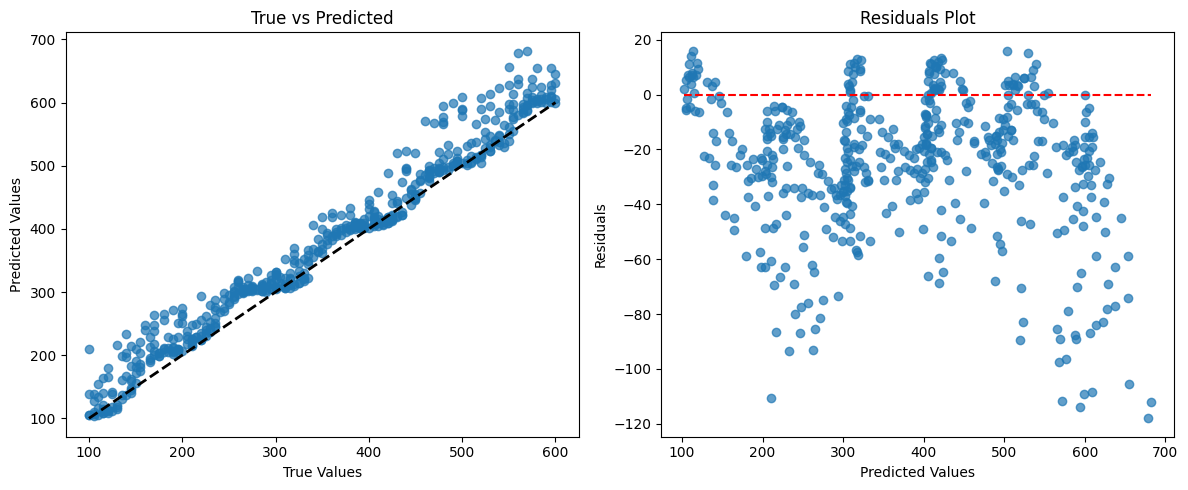

Training Random Forest for Max_GroupBy...
(547, 5000, 1) (547,) (512, 5000, 1) (512,)
Mean Squared Error (MSE): 1334915.5859
R² Score: 0.3496


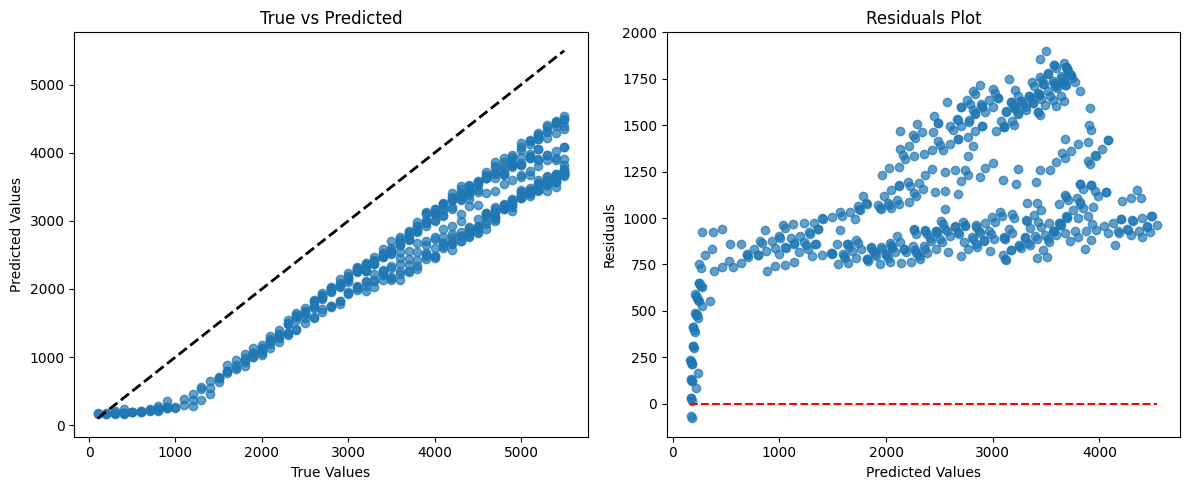

Training Random Forest for Avg_Sliding...
(509, 5000, 1) (509,) (509, 5000, 1) (509,)
Mean Squared Error (MSE): 11530.2284
R² Score: 0.9969


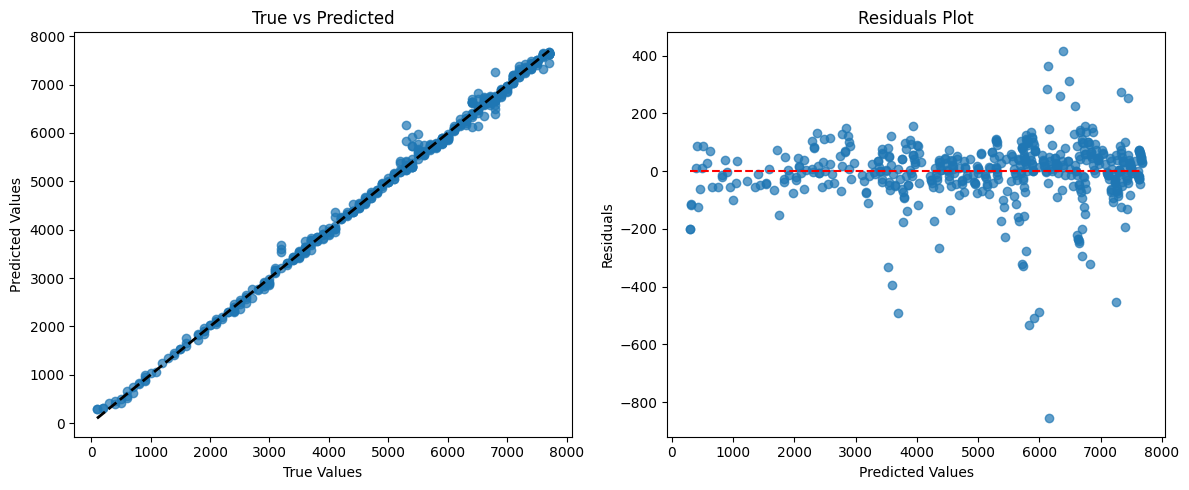

Training Random Forest for Avg_Partition...
(535, 5000, 1) (535,) (536, 5000, 1) (536,)
Mean Squared Error (MSE): 124440.3664
R² Score: 0.8140


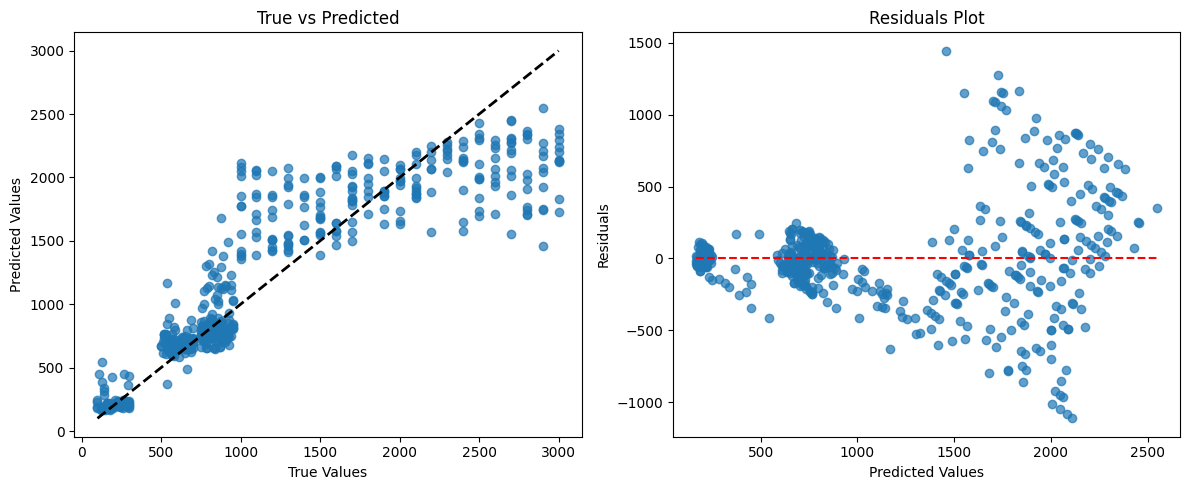

Training Random Forest for Count_By_Auction...
(375, 5000, 1) (375,) (375, 5000, 1) (375,)
Mean Squared Error (MSE): 28.0772
R² Score: 0.9849


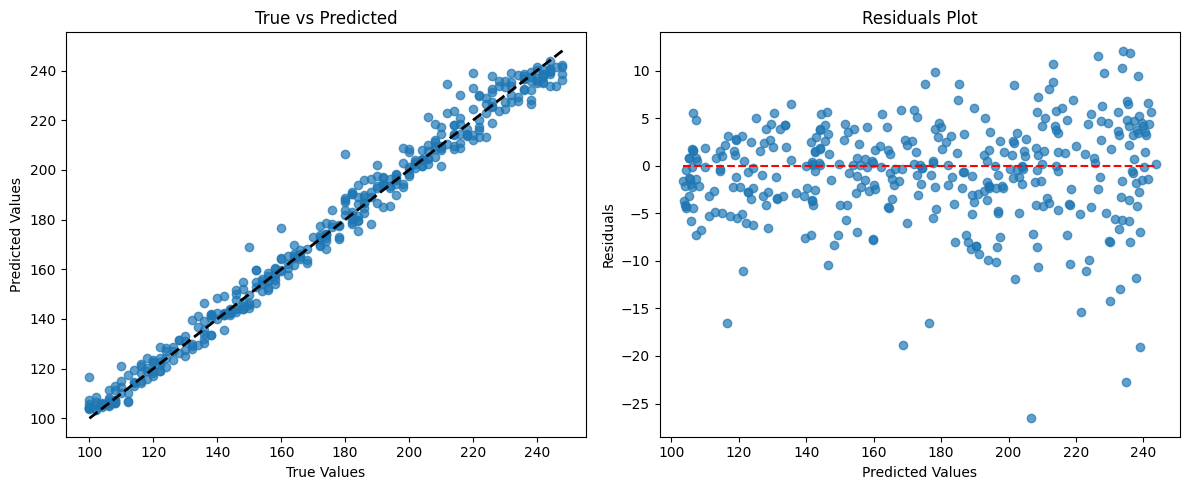

In [38]:
rf_window_models = {}

for operator in data_files:
    print(f"Training Random Forest for {operator}...")
    rf_window_models[operator] = train_and_evaluate_ml_model(operator, 'window_time', train_and_evaluate_rf, {
        'n_estimators': 200,
        'max_depth': None,
        'random_state': 42
    })

Training Random Forest for Join...
(504, 5000, 1) (504,) (505, 5000, 1) (505,)
Mean Squared Error (MSE): 144848.0903
R² Score: -174.3285


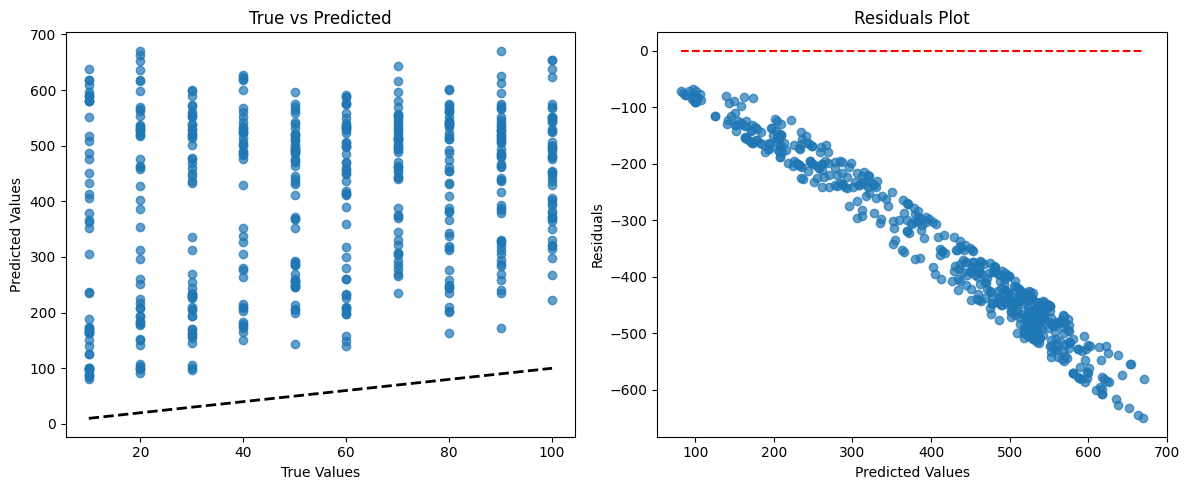

Training Random Forest for Max_GroupBy...
(547, 5000, 1) (547,) (512, 5000, 1) (512,)
Mean Squared Error (MSE): 485037.0375
R² Score: 0.4482


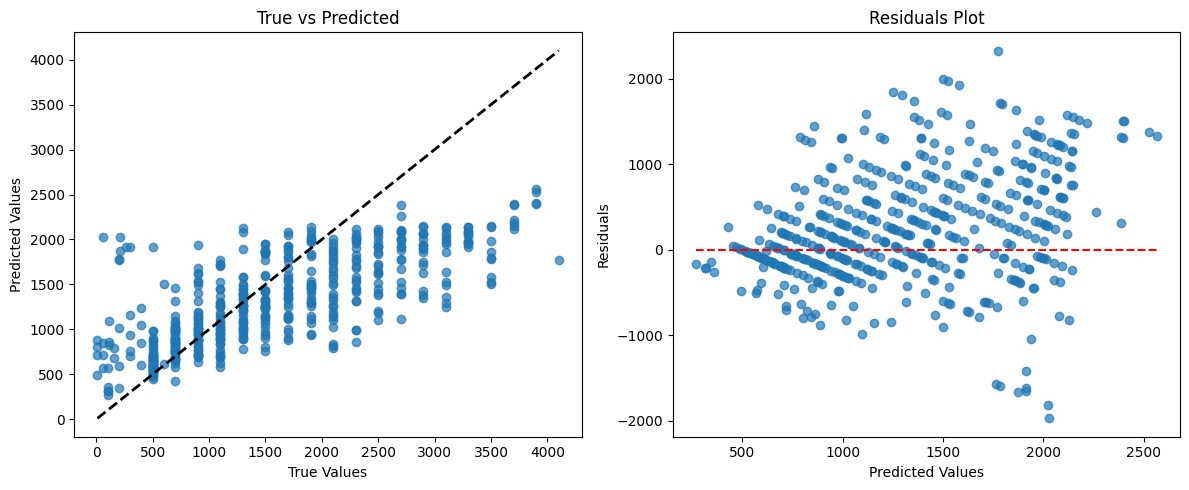

Training Random Forest for Avg_Sliding...
(509, 5000, 1) (509,) (509, 5000, 1) (509,)
Mean Squared Error (MSE): 840836.2220
R² Score: 0.4852


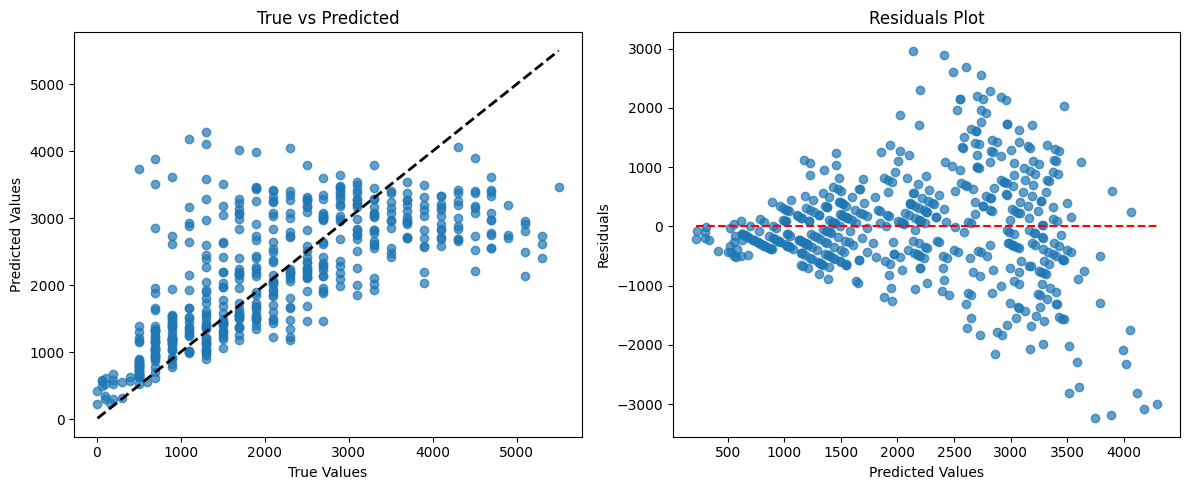

Training Random Forest for Avg_Partition...
(535, 5000, 1) (535,) (536, 5000, 1) (536,)
Mean Squared Error (MSE): 8439.9383
R² Score: 0.6360


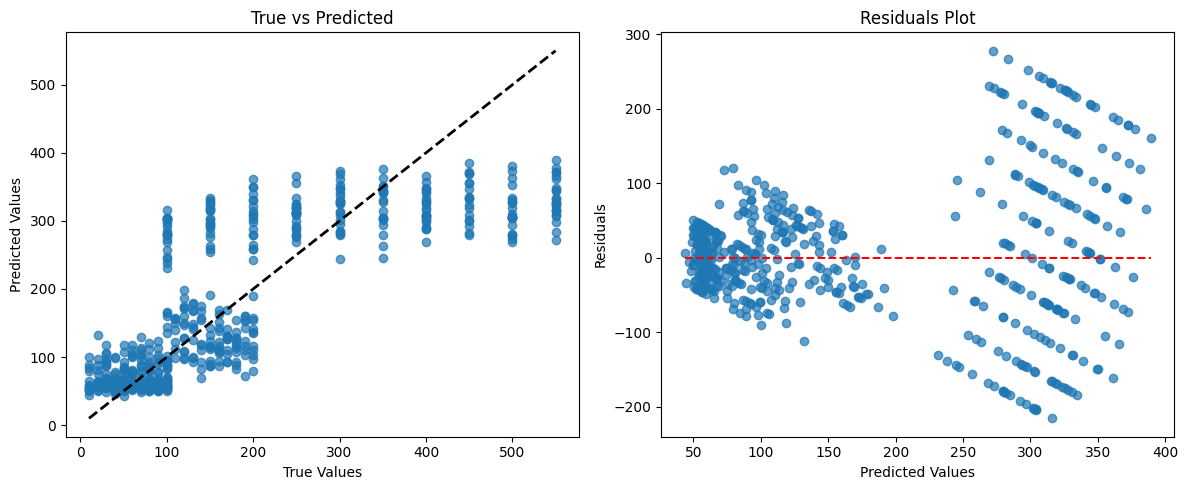

Training Random Forest for Count_By_Auction...
(375, 5000, 1) (375,) (375, 5000, 1) (375,)
Mean Squared Error (MSE): 28.9536
R² Score: 0.9652


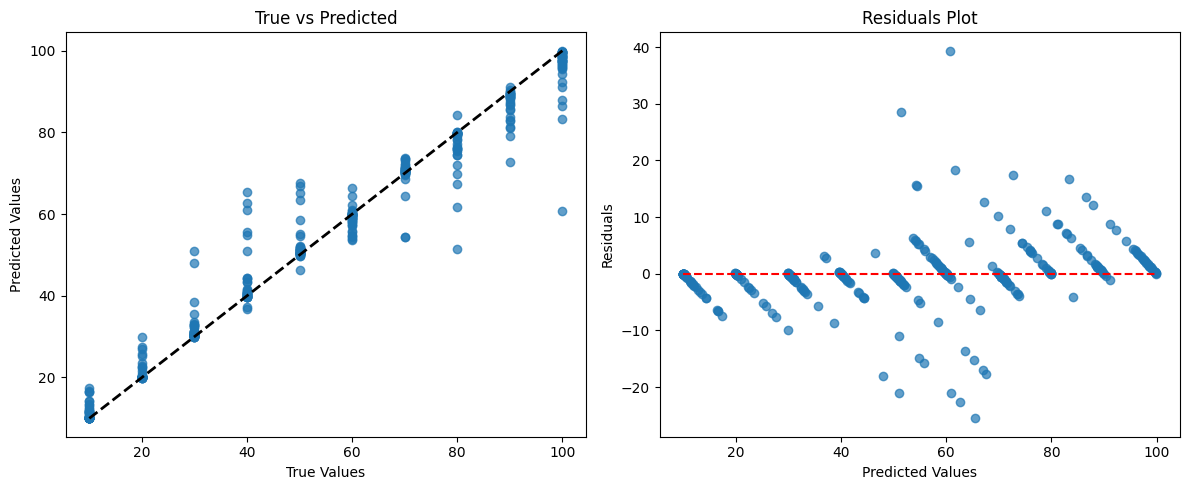

In [39]:
rf_sliding_step_models = {}

for operator in data_files:
    print(f"Training Random Forest for {operator}...")
    rf_sliding_step_models[operator] = train_and_evaluate_ml_model(operator, 'sliding_step', train_and_evaluate_rf, {
        'n_estimators': 200,
        'max_depth': None,
        'random_state': 42
    })

# SVM

Training SVR for join...
Best parameters: {'C': 100, 'epsilon': 0.1, 'gamma': 'auto'}
Best cross-validation score: 0.9433913714012631
Mean Squared Error (MSE): 147587.3358
R² Score: 0.9277


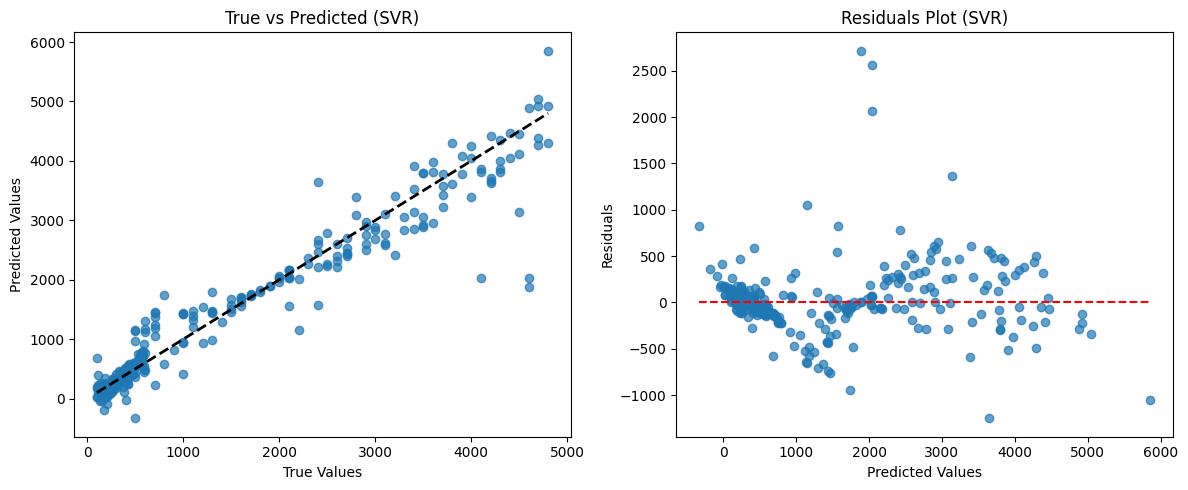

Training SVR for Max_GroupBy...
Best parameters: {'C': 100, 'epsilon': 0.01, 'gamma': 0.01}
Best cross-validation score: 0.8832038982368168
Mean Squared Error (MSE): 255895.1667
R² Score: 0.8537


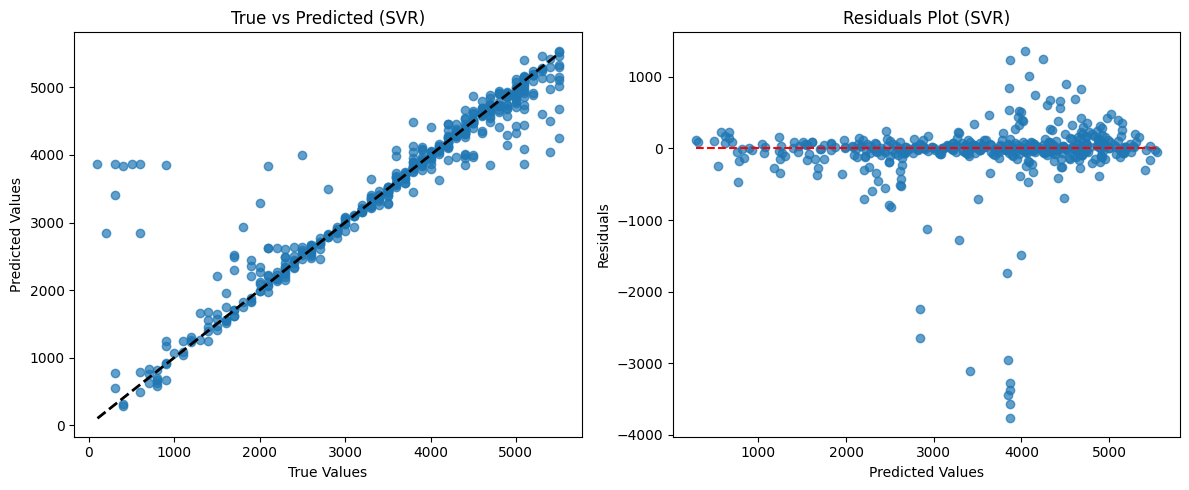

Training SVR for Avg_Sliding...
Best parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 'auto'}
Best cross-validation score: 0.9184797529992741
Mean Squared Error (MSE): 248792.9761
R² Score: 0.9358


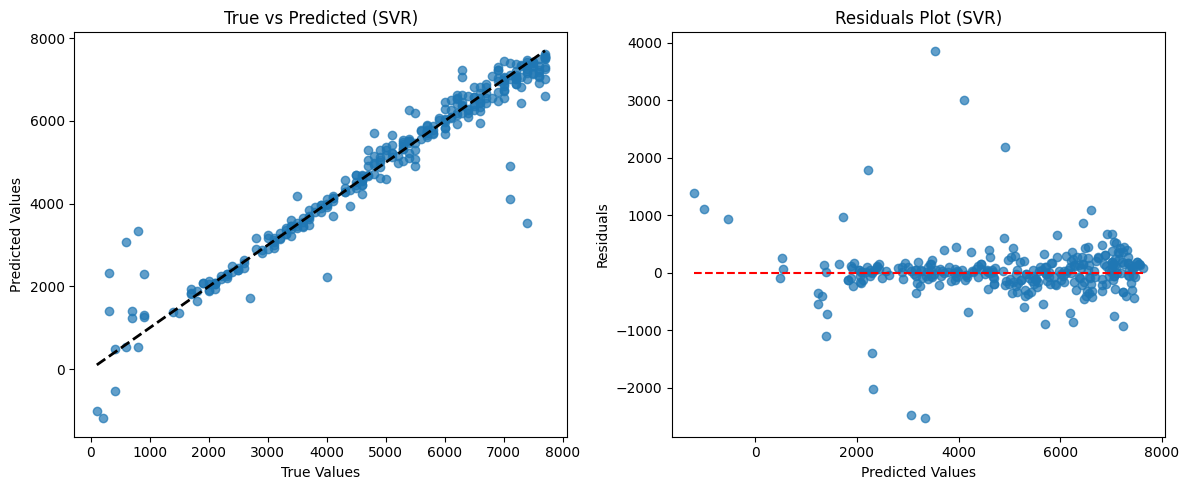

Training SVR for Avg_Partition...
Best parameters: {'C': 100, 'epsilon': 0.1, 'gamma': 0.01}
Best cross-validation score: 0.8650645503317737
Mean Squared Error (MSE): 112245.1680
R² Score: 0.8396


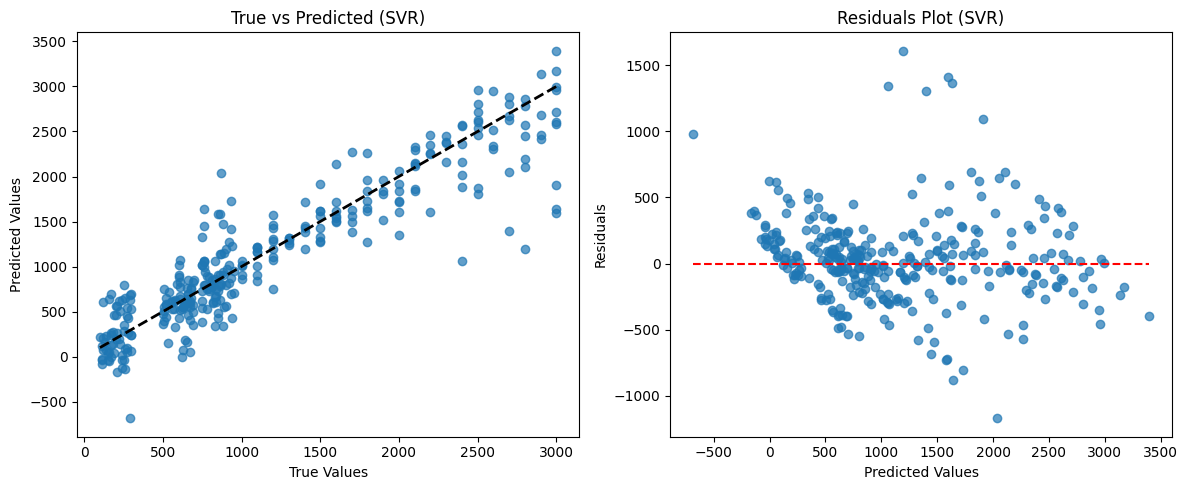

Training SVR for Count_By_Auction...
Best parameters: {'C': 100, 'epsilon': 0.1, 'gamma': 'scale'}
Best cross-validation score: 0.947736850613134
Mean Squared Error (MSE): 73.6127
R² Score: 0.9585


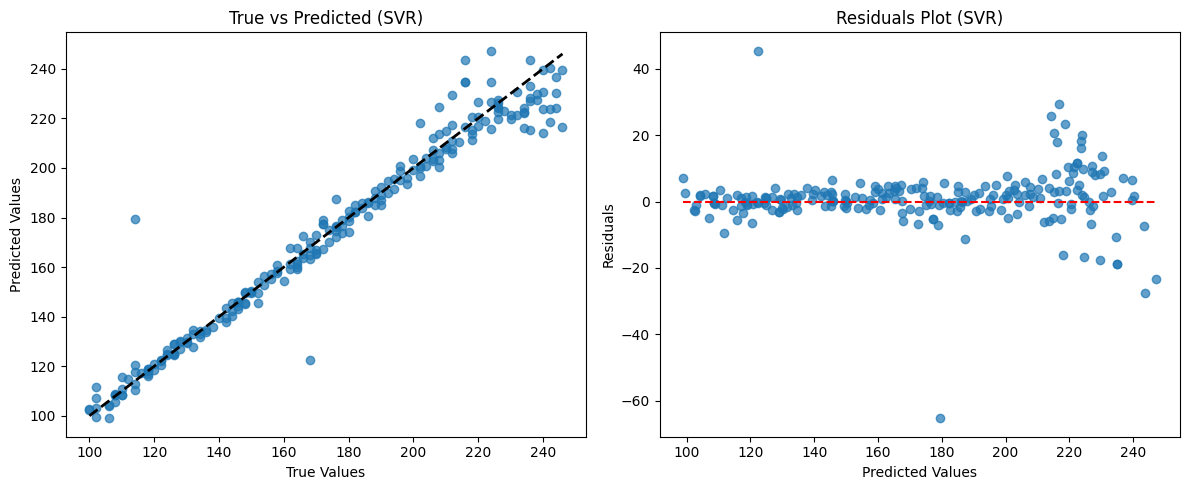

In [16]:
svr_window_models = {}


for operator in data_files:
    x_train = data_files[operator]['train_data']
    y_train = data_files[operator]['train_window_time']
    x_test = data_files[operator]['test_data']
    y_test = data_files[operator]['test_window_time']

    # Convert to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    print(f"Training SVR for {operator}...")
    svr_window_models[operator] = {
        'model': None,
        'params': None,
        'scaler_x': None, 
        'scaler_y': None
    }
    svr_window_models[operator]['model'], 
    svr_window_models[operator]['params'], 
    svr_window_models[operator]['scaler_x'], 
    svr_window_models[operator]['scaler_y'] = svr_grid_search(x_train, y_train, x_test, y_test)

Training SVR for Join...
Best parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 'auto'}
Best cross-validation score: 0.24902124666185688
Mean Squared Error (MSE): 94179.3808
R² Score: -112.9975


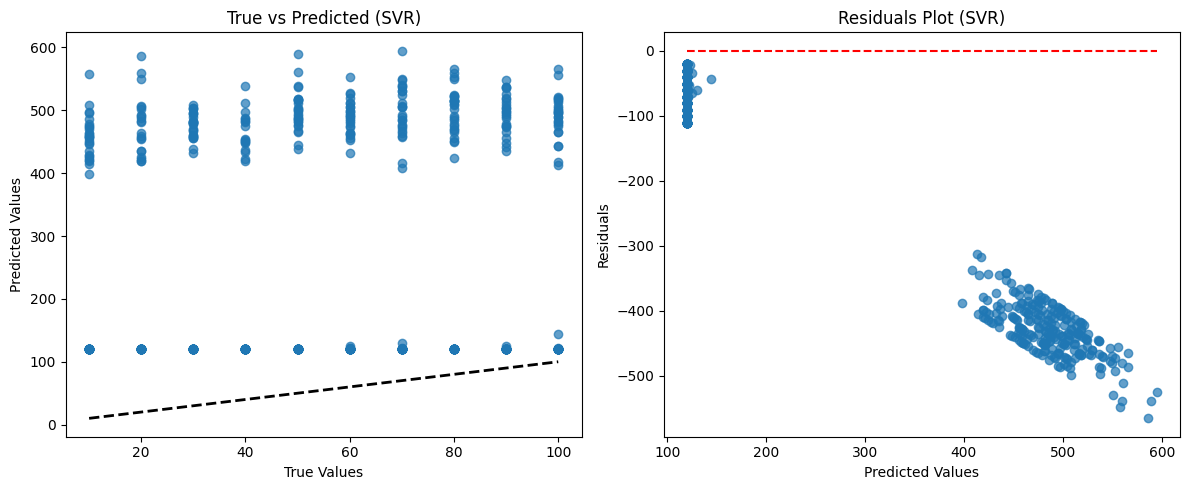

Training SVR for Max_GroupBy...
Best parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 'scale'}
Best cross-validation score: 0.5184826647992749
Mean Squared Error (MSE): 553497.4629
R² Score: 0.3703


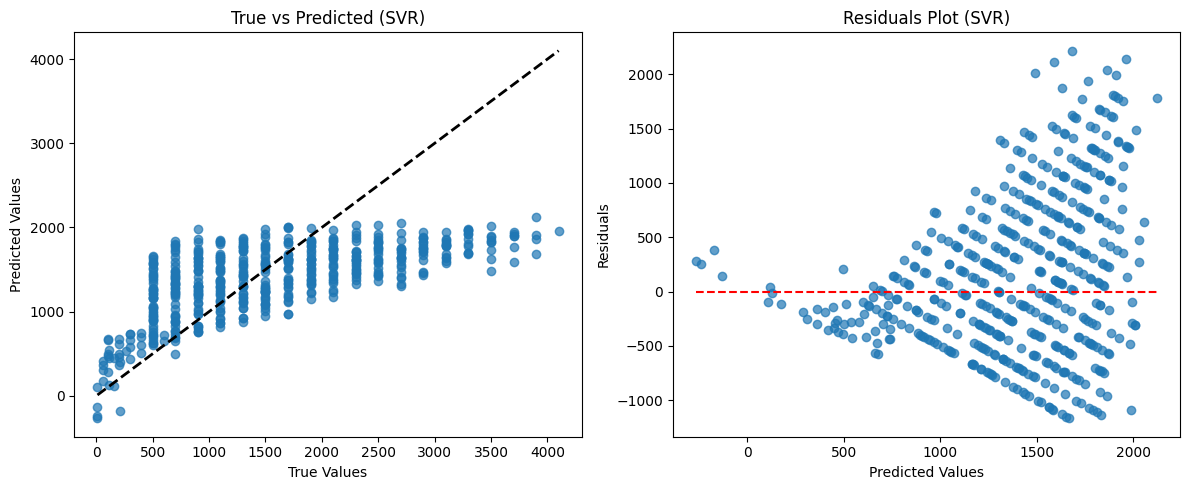

Training SVR for Avg_Sliding...
Best parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 'auto'}
Best cross-validation score: 0.2144757954444861
Mean Squared Error (MSE): 1275000.6526
R² Score: 0.2376


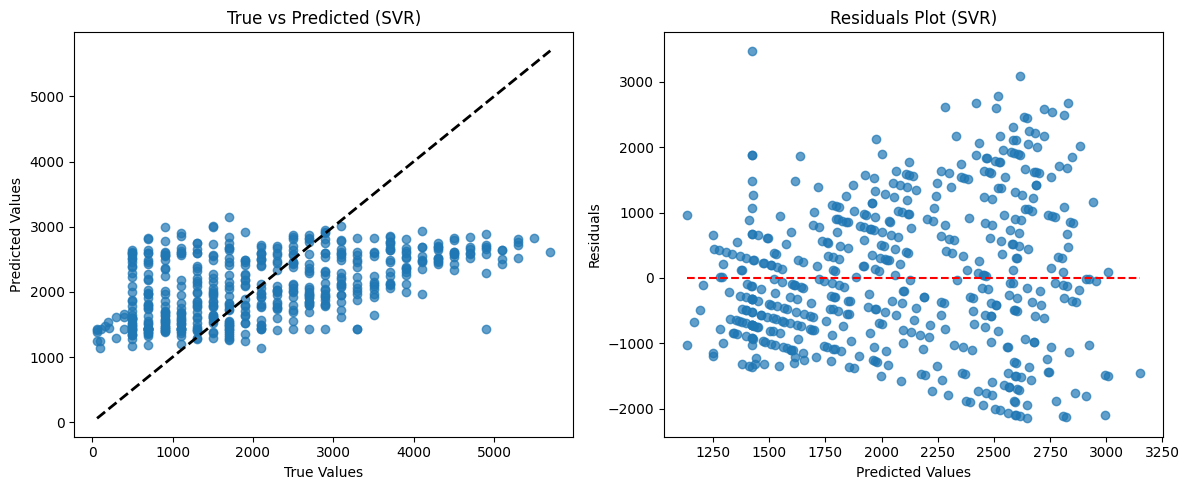

Training SVR for Avg_Partition...
Best parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 'scale'}
Best cross-validation score: 0.5643404054281584
Mean Squared Error (MSE): 9779.5923
R² Score: 0.5529


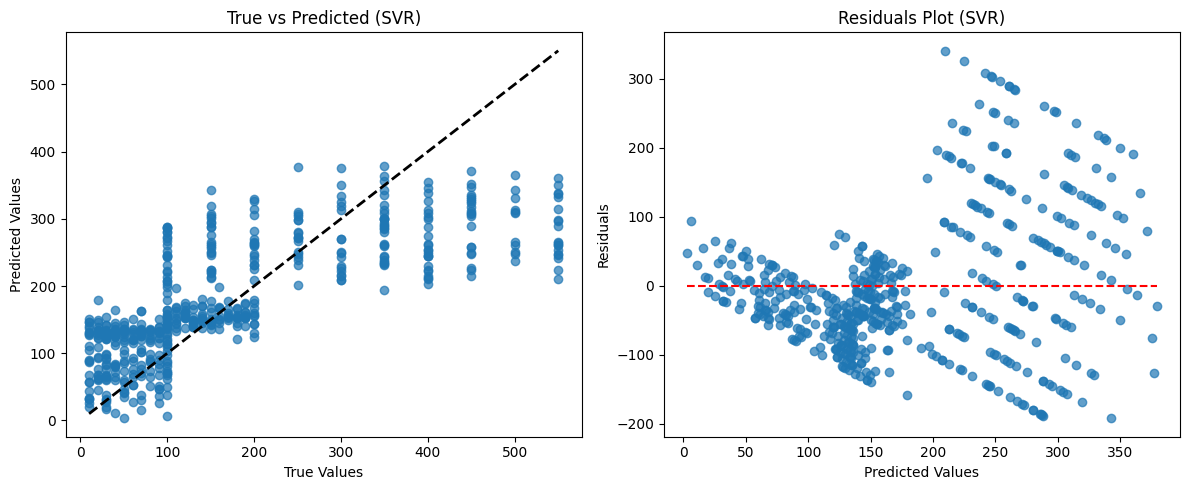

Training SVR for Count_By_Auction...
Best parameters: {'C': 1, 'epsilon': 0.1, 'gamma': 'auto'}
Best cross-validation score: 0.68666776808156
Mean Squared Error (MSE): 303.3223
R² Score: 0.6480


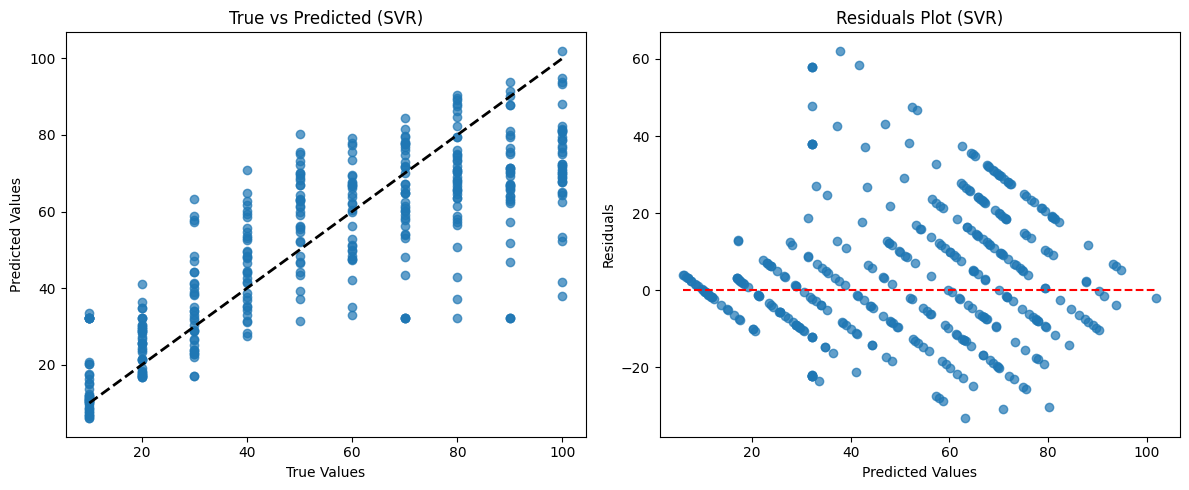

In [22]:
svr_sliding_step_models = {}


for operator in data_files:
    x_train = data_files[operator]['train_data']
    y_train = data_files[operator]['train_sliding_step']
    x_test = data_files[operator]['test_data']
    y_test = data_files[operator]['test_sliding_step']

    # Convert to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    print(f"Training SVR for {operator}...")
    svr_sliding_step_models[operator] = {
        'model': None,
        'params': None,
        'scaler_x': None, 
        'scaler_y': None
    }
    svr_sliding_step_models[operator]['model'], 
    svr_sliding_step_models[operator]['params'], 
    svr_sliding_step_models[operator]['scaler_x'], 
    svr_sliding_step_models[operator]['scaler_y'] = svr_grid_search(x_train, y_train, x_test, y_test)

# XGB

Training SVR for Join...
Mean Squared Error (MSE): 92315.0000
R² Score: -3.4300


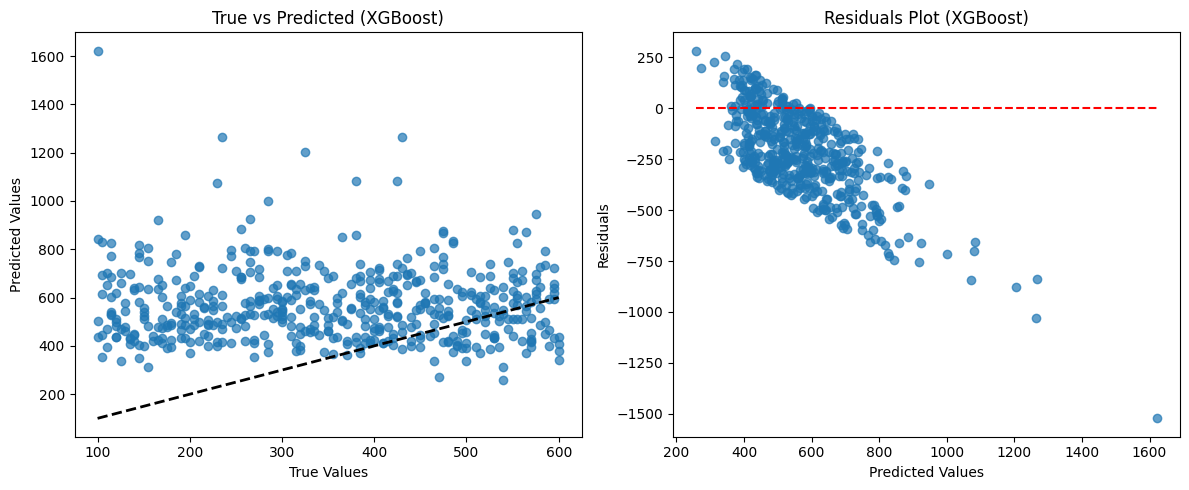

Training SVR for Max_GroupBy...
Mean Squared Error (MSE): 942437.3750
R² Score: 0.5408


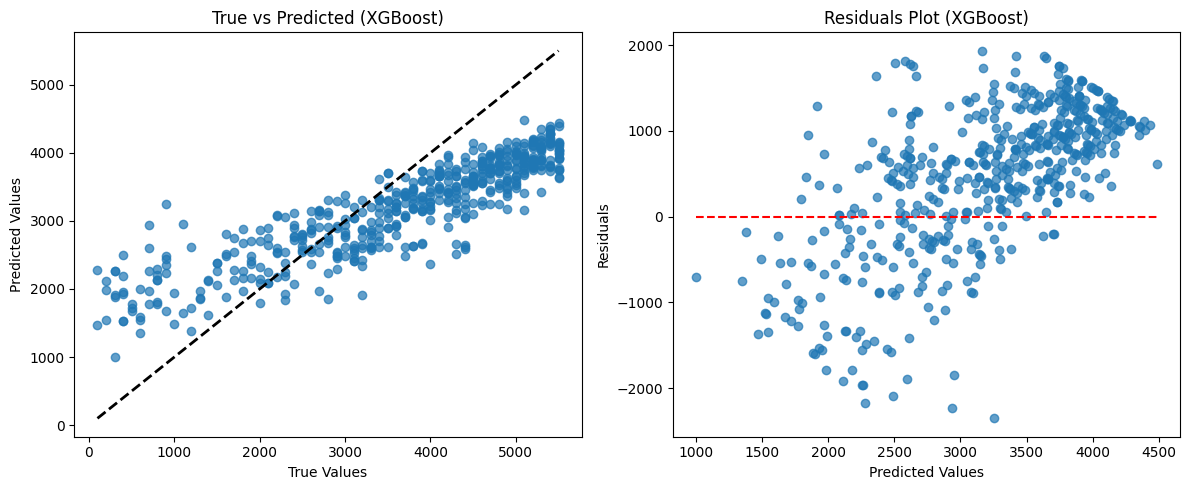

Training SVR for Avg_Sliding...
Mean Squared Error (MSE): 205295.5781
R² Score: 0.9421


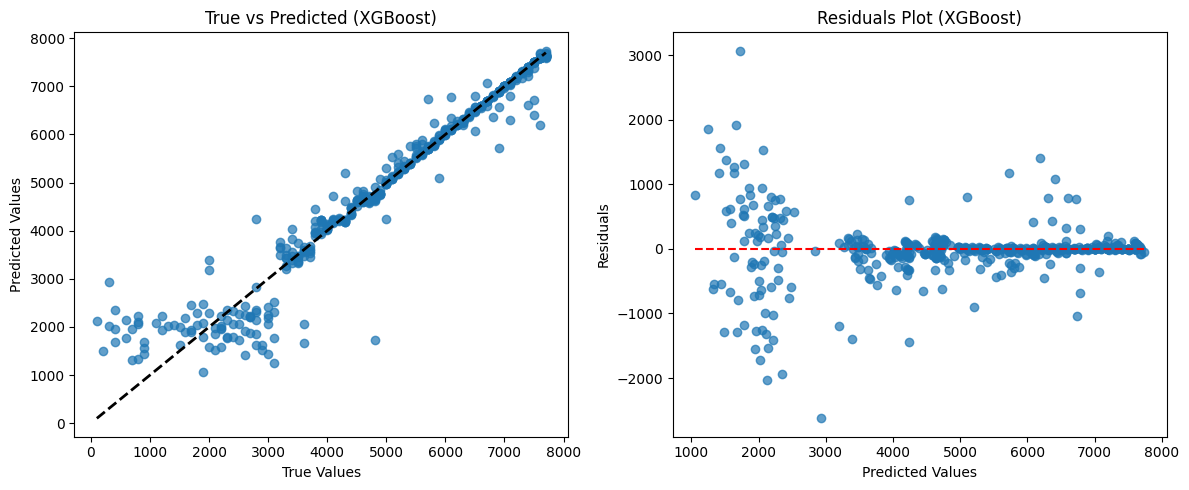

Training SVR for Avg_Partition...
Mean Squared Error (MSE): 171325.5469
R² Score: 0.7554


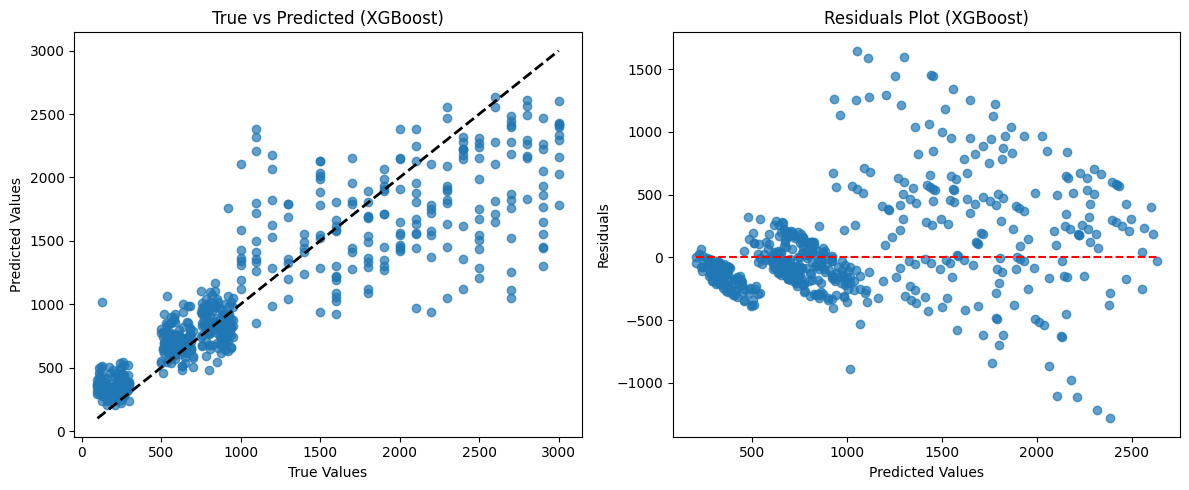

Training SVR for Count_By_Auction...
Mean Squared Error (MSE): 1980.6064
R² Score: -0.0951


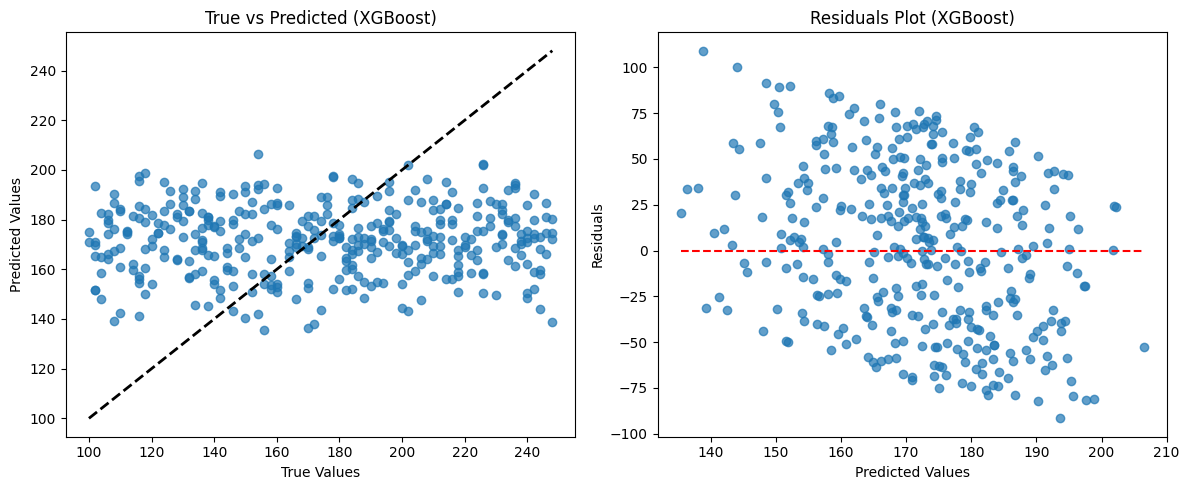

In [ ]:
xgboost_window_models = {}


for operator in data_files:
    x_train = data_files[operator]['train_data']
    y_train = data_files[operator]['train_window_time']
    x_test = data_files[operator]['test_data']
    y_test = data_files[operator]['test_window_time']

    # Convert to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    print(f"Training SVR for {operator}...")
    xgboost_window_models[operator] = {
        'model': None,
        'params': None,
        'scaler_x': None, 
        'scaler_y': None
    }
    xgboost_window_models[operator]['model'], 
    xgboost_window_models[operator]['params'], 
    xgboost_window_models[operator]['scaler_x'], 
    xgboost_window_models[operator]['scaler_y'] = train_and_evaluate_xgb(x_train, y_train, x_test, y_test)

Training XGB for Join...
Mean Squared Error (MSE): 223250.0000
R² Score: -269.2285


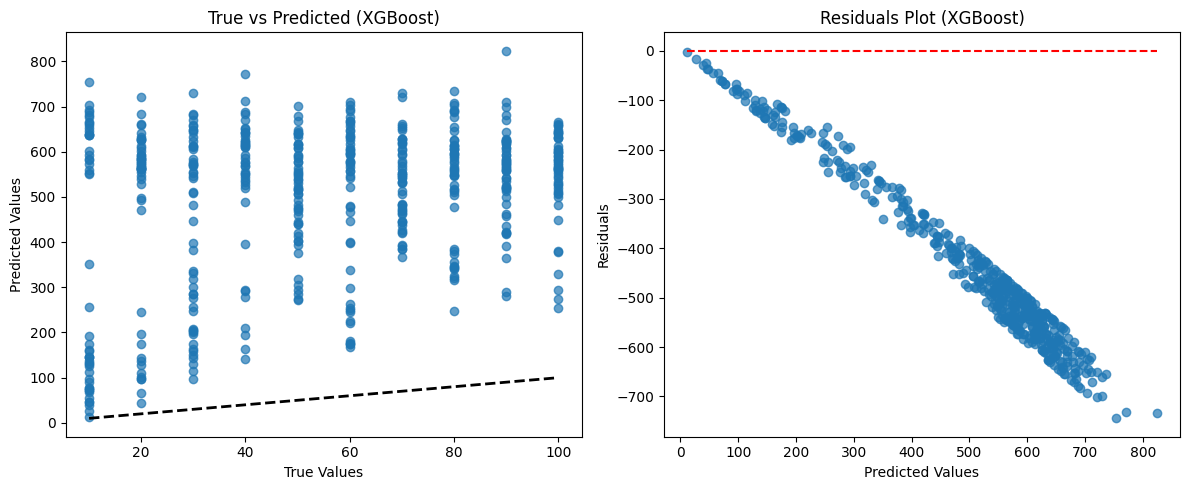

Training XGB for Max_GroupBy...
Mean Squared Error (MSE): 796866.3750
R² Score: 0.0934


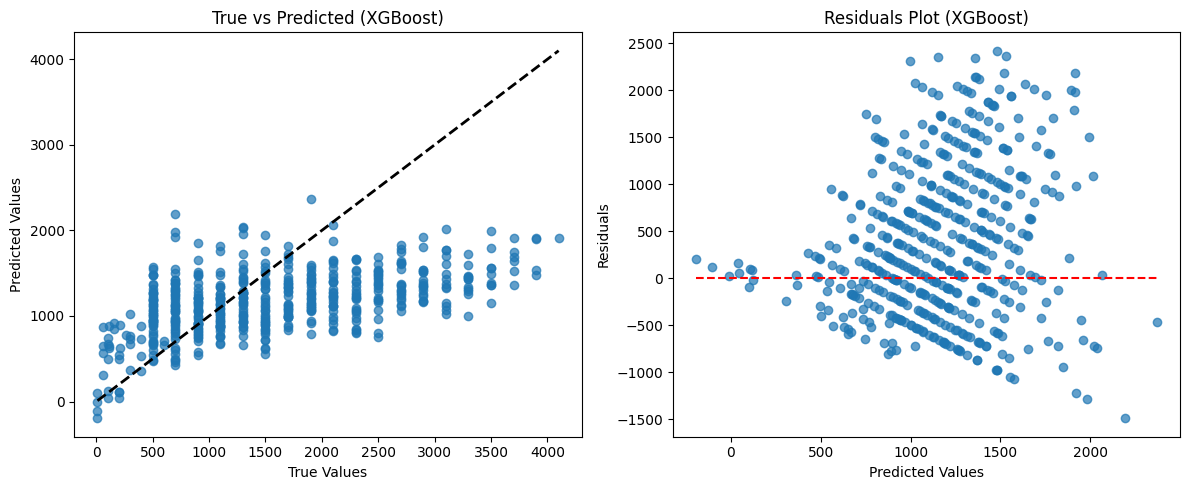

Training XGB for Avg_Sliding...
Mean Squared Error (MSE): 1350718.2500
R² Score: 0.1924


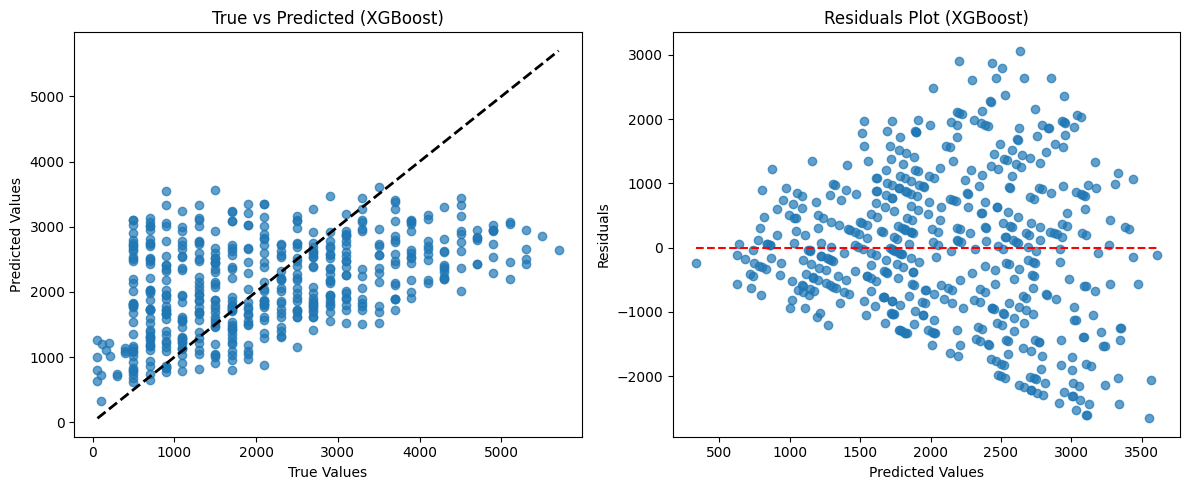

Training XGB for Avg_Partition...
Mean Squared Error (MSE): 11554.5938
R² Score: 0.4717


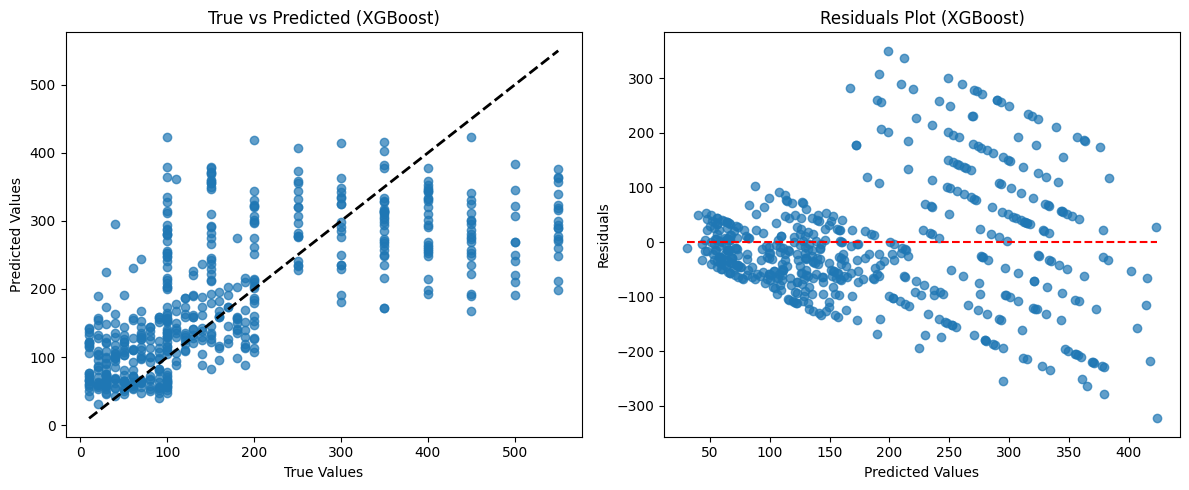

Training XGB for Count_By_Auction...
Mean Squared Error (MSE): 715.1257
R² Score: 0.1702


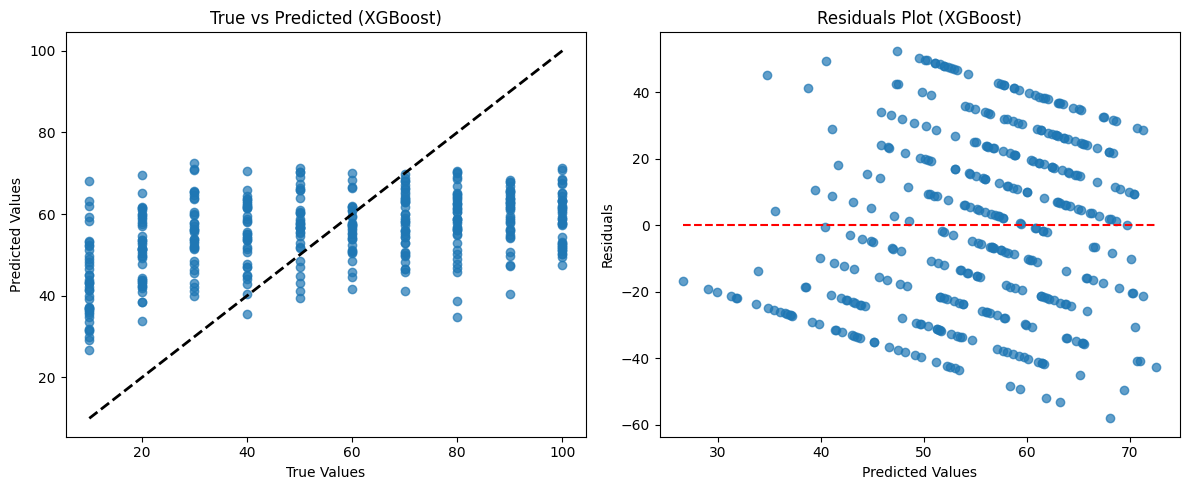

In [20]:
xgb_sliding_step_models = {}


for operator in data_files:
    x_train = data_files[operator]['train_data']
    y_train = data_files[operator]['train_sliding_step']
    x_test = data_files[operator]['test_data']
    y_test = data_files[operator]['test_sliding_step']

    # Convert to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    print(f"Training XGB for {operator}...")
    xgb_sliding_step_models[operator] = {
        'model': None,
        'params': None,
        'scaler_x': None, 
        'scaler_y': None
    }
    xgb_sliding_step_models[operator]['model'], 
    xgb_sliding_step_models[operator]['params'], 
    xgb_sliding_step_models[operator]['scaler_x'], 
    xgb_sliding_step_models[operator]['scaler_y'] = train_and_evaluate_xgb(x_train, y_train, x_test, y_test)

In [ ]:
# def train_and_evaluate_xgb(X_train, y_train, X_test, y_test, n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42):
#     # Scale the data (XGBoost works without scaling, but scaling sometimes still helps)
#     scaler_X = StandardScaler()
#     scaler_y = StandardScaler()
    
#     X_train_scaled = scaler_X.fit_transform(X_train)
#     X_test_scaled = scaler_X.transform(X_test)
    
#     y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
    
#     # Train the XGBoost model
#     model = XGBRegressor(
#         n_estimators=n_estimators,
#         learning_rate=learning_rate,
#         max_depth=max_depth,
#         random_state=random_state,
#         objective='reg:squarederror'  # important for regression
#     )
#     model.fit(X_train_scaled, y_train_scaled)
    
#     # Predict
#     y_pred_scaled = model.predict(X_test_scaled)
#     y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    
#     # Evaluate
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
    
#     print(f"Mean Squared Error (MSE): {mse:.4f}")
#     print(f"R² Score: {r2:.4f}")
    
#     # Plot True vs Predicted
#     plt.figure(figsize=(12, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.scatter(y_test, y_pred, alpha=0.7)
#     plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
#     plt.xlabel('True Values')
#     plt.ylabel('Predicted Values')
#     plt.title('True vs Predicted (XGBoost)')

#     # Plot Residuals
#     plt.subplot(1, 2, 2)
#     residuals = y_test - y_pred
#     plt.scatter(y_pred, residuals, alpha=0.7)
#     plt.hlines(0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='dashed')
#     plt.xlabel('Predicted Values')
#     plt.ylabel('Residuals')
#     plt.title('Residuals Plot (XGBoost)')
    
#     plt.tight_layout()
#     plt.show()
    
#     return model, scaler_X, scaler_y